# Artificial Neural Network and Deep Learning - Challenge 1

## Hyperparameters

In [ ]:
SEED = 100

# Training
EPOCHS = 500                    # Maximum epochs (increase to improve performance)
PATIENCE = 50                   # Early stopping patience (increase to improve performance)
VERBOSE = 1                     # Print frequency

# Optimisation
LEARNING_RATE = 0.0001          # Learning rate
BATCH_SIZE = 32                 # Batch size
WINDOW_SIZE = 100               # Input window size
STRIDE = 25                     # Input stride

# Architecture
HIDDEN_LAYERS = 2               # Hidden layers
HIDDEN_SIZE = 256               # Neurons per layer
RNN_TYPE = 'LSTM'               # Type of RNN architecture ['RNN', 'LSTM', 'GRU']
BIDIRECTIONAL = True            # Bidirectional RNN

# Regularisation
NOISE_STD_DEV = 0.1             # Data Augmentation: Added noise on training dataset
DROPOUT_RATE = 0.2              # Dropout probability
L1_LAMBDA = 0.0                 # L1 penalty
L2_LAMBDA = 0.001               # L2 penalty

# Static NN Branch
USE_STATIC_FEATURES = True      # Enable Training on static features
STATIC_HIDDEN_SIZE = 8         # Size of the new MLP branch

# Prediction
PREDICT_FLAG = False            # Enable test set prediction

#-------------------# 

# Cross-validation 
RUN_GRID_SEARCH = False 
CROSS_VALIDATION_FLAG = False   # Enable k-fold cross-validation
K = 5                           # Number of splits (5 and 10 are considered good values)
N_VAL_USERS = 5                 # Number of users for validation split
N_TEST_USERS = 5                # Number of users for test split



## Libraries and dataset import

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   
import random
import torch
import os
from itertools import product
from itertools import chain

from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import f1_score
import torch.nn as nn
from datetime import datetime 


random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

df_train = pd.read_csv('pirate_pain_train.csv')
df_labels = pd.read_csv('pirate_pain_train_labels.csv')



PyTorch version: 2.9.0+cu128
Device: cuda


In [15]:
def build_fixed_sequences(df_features, df_labels, feature_cols, joint_cols, label_map, window=200, stride=50):

    dataset = []
    labels = []
    sample_indices = []
    n_features = len(feature_cols)

    print(f"Building fixed sequences with window={window}, stride={stride}...")

    # Iterate over unique sample indices
    for sid in df_features['sample_index'].unique():
        
        # 1. Get features
        temp_features = df_features[df_features['sample_index'] == sid].sort_values('time')[feature_cols].values
        
        # 2. Get label
        label_str = df_labels[df_labels['sample_index'] == sid]['label'].values[0]
        label_numeric = label_map[label_str]

        # 3. Normalize
        temp_features_tensor = torch.FloatTensor(temp_features)
        joint_data = temp_features_tensor[:, :len(joint_cols)]
        joint_min = joint_data.min(dim=0)[0]
        joint_max = joint_data.max(dim=0)[0]
        joint_range = joint_max - joint_min
        joint_range[joint_range == 0] = 1
        normalized_joints = 2 * ((joint_data - joint_min) / joint_range) - 1
        temp_features_tensor[:, :len(joint_cols)] = normalized_joints
        temp_features_normalized = temp_features_tensor.numpy()

        # 4. Apply padding (from your original logic)
        padding_len = window - len(temp_features_normalized) % window
        
        if padding_len < window: # Only add padding if not an exact multiple
            padding = np.zeros((padding_len, n_features), dtype='float32')
            temp_features_padded = np.concatenate((temp_features_normalized, padding))
        else:
            temp_features_padded = temp_features_normalized # Already an exact multiple
        # ----------------------------------------------

        # 5. Apply windowing logic
        idx = 0
        while idx + window <= len(temp_features_padded):
            dataset.append(temp_features_padded[idx:idx + window])
            labels.append(label_numeric)
            sample_indices.append(sid) 
            idx += stride

    dataset = np.array(dataset, dtype=np.float32)
    labels = np.array(labels, dtype=np.int64)

    return dataset, labels, np.array(sample_indices)

## Preprocessing

### Windows Creation

In [16]:
# --- 1. Define feature columns and label map ---
joint_cols = [c for c in df_train.columns if c.startswith('joint_')]
pain_cols = [c for c in df_train.columns if c.startswith('pain_survey_')]
static_cols_raw = [c for c in df_train.columns if c.startswith('n_')] 
feature_cols = joint_cols + pain_cols 
input_size = len(feature_cols) # This is the input size for the RNN

# Create label map
unique_labels = sorted(df_labels['label'].unique())
label_map = {label: i for i, label in enumerate(unique_labels)}
num_classes = len(label_map)

print(f"Temporal Feature columns: {input_size}")
print(f"Found Raw Static Feature columns: {static_cols_raw}")
print(f"Label map: {label_map}")

# --- 2. Split by Sample Index (Leakage Fix) ---
unique_sids = df_labels['sample_index'].unique()
train_sids, val_sids = train_test_split(
    unique_sids,
    test_size=0.2,
    random_state=SEED,
    stratify=df_labels['label'] 
)
df_train_split = df_train[df_train['sample_index'].isin(train_sids)]
df_labels_train_split = df_labels[df_labels['sample_index'].isin(train_sids)]
df_val_split = df_train[df_train['sample_index'].isin(val_sids)]
df_labels_val_split = df_labels[df_labels['sample_index'].isin(val_sids)]

# --- 3. Build all sequences ---
X_train, y_train, train_window_sids = build_fixed_sequences(
    df_train_split, df_labels_train_split, 
    feature_cols, joint_cols, label_map,
    window=WINDOW_SIZE,
    stride=STRIDE
)
X_val, y_val, val_window_sids = build_fixed_sequences(
    df_val_split, df_labels_val_split, 
    feature_cols, joint_cols, label_map,
    window=WINDOW_SIZE,
    stride=STRIDE
)
print(f"\nTotal windows created (Train): {len(X_train)}")
print(f"Total windows created (Val):   {len(X_val)}")

# --- 4. Static Data ---
print("\nStarting static feature engineering...")

def engineer_static_features(raw_df):
    """
    Applies consistent feature engineering rules to a raw static dataframe.
    """
    engineered_df = pd.DataFrame(index=raw_df.index)
    
    # This logic is now reusable and based on the training logic
    if 'n_legs' in raw_df:
        engineered_df['n_legs'] = np.where(raw_df['n_legs'] == '2', 2.0, 1.0)
    if 'n_arms' in raw_df:
        engineered_df['n_arms'] = np.where(raw_df['n_arms'] == '2', 2.0, 1.0)
    if 'n_eyes' in raw_df:
        engineered_df['n_eyes'] = np.where(raw_df['n_eyes'] == '2', 2.0, 1.0)
        
    # Add any other static columns that don't need special engineering
    for col in raw_df.columns:
        if col not in ['n_legs', 'n_arms', 'n_eyes'] and col not in engineered_df.columns:
            # Simple numeric conversion for other 'n_' cols
            engineered_df[col] = pd.to_numeric(raw_df[col], errors='coerce').fillna(0)
            
    return engineered_df

# Get raw static features for ALL data
df_static_raw = df_train.drop_duplicates(subset=['sample_index']).set_index('sample_index')[static_cols_raw]

# Engineer features for ALL data
df_static_engineered = engineer_static_features(df_static_raw)
print("Engineering complete. Normalizing features...")


df_static_train_only = df_static_engineered.loc[train_sids]
STATIC_TRAIN_MIN = df_static_train_only.min()
STATIC_TRAIN_MAX = df_static_train_only.max()


STATIC_FEATURES_LIST_ENGINEERED = list(df_static_engineered.columns)

# Normalize all data using ONLY train stats
df_static_norm = (df_static_engineered - STATIC_TRAIN_MIN) / (STATIC_TRAIN_MAX - STATIC_TRAIN_MIN)
df_static_norm = df_static_norm.fillna(0) # Handle any NaNs
print(f"\nCreated normalized static features for {len(df_static_norm)} samples.")
print(f"New static features: {STATIC_FEATURES_LIST_ENGINEERED}")


# --- 5. Create new, flexible Dataset ---
class PainDataset(Dataset):
    def __init__(self, X_temporal, y, window_sample_indices, static_df, 
                 is_train=False, n_joint_cols=0, noise_level=0.01):
        
        self.X_temporal = torch.tensor(X_temporal, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        self.window_sample_indices = window_sample_indices
        self.static_data = torch.tensor(static_df.values, dtype=torch.float32)
        self.static_map = {sid: i for i, sid in enumerate(static_df.index)}
        self.is_train = is_train
        self.n_joint_cols = n_joint_cols
        self.noise_level = noise_level
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        x_temporal_sample = self.X_temporal[idx].clone() 
        y_sample = self.y[idx]
        
        if self.is_train and self.noise_level > 0:
            noise = torch.randn(x_temporal_sample.shape[0], self.n_joint_cols) * self.noise_level
            x_temporal_sample[:, :self.n_joint_cols] = x_temporal_sample[:, :self.n_joint_cols] + noise.to(x_temporal_sample.device)
        
        sample_index = self.window_sample_indices[idx]
        
        # Handle case where a sample_index might be missing from static_map (e.g., in edge cases)
        static_idx_lookup = self.static_map.get(sample_index)
        if static_idx_lookup is None:
            # Fallback: return zeros if sample is missing
            print(f"Warning: Missing static data for sample_index {sample_index}. Returning zeros.")
            x_static_sample = torch.zeros(self.static_data.shape[1], dtype=torch.float32)
        else:
            x_static_sample = self.static_data[static_idx_lookup]
            
        return (x_temporal_sample, x_static_sample), y_sample

# --- 6. Create new DataLoaders ---
n_joint_cols = len(joint_cols) 

train_dataset = PainDataset(
    X_train, y_train, train_window_sids, df_static_norm,
    is_train=True, 
    n_joint_cols=n_joint_cols, 
    noise_level=NOISE_STD_DEV
)
val_dataset = PainDataset(
    X_val, y_val, val_window_sids, df_static_norm,
    is_train=False
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Temporal Feature columns: 35
Found Raw Static Feature columns: ['n_legs', 'n_hands', 'n_eyes']
Label map: {'high_pain': 0, 'low_pain': 1, 'no_pain': 2}
Building fixed sequences with window=100, stride=25...
Building fixed sequences with window=100, stride=25...

Total windows created (Train): 2640
Total windows created (Val):   665

Starting static feature engineering...
Engineering complete. Normalizing features...

Created normalized static features for 661 samples.
New static features: ['n_legs', 'n_eyes', 'n_hands']


### Cross Entropy weighting

label
no_pain      0.773071
low_pain     0.142209
high_pain    0.084720
Name: proportion, dtype: float64


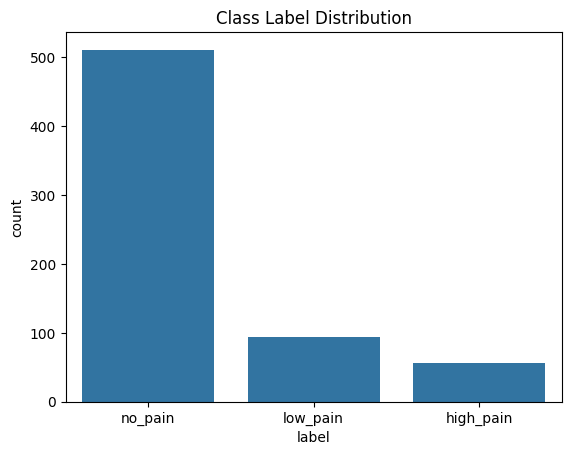

Label proportions:
 label
high_pain    0.084720
low_pain     0.142209
no_pain      0.773071
Name: proportion, dtype: float64

Calculated Weights:
 label
high_pain    0.586395
low_pain     0.349342
no_pain      0.064263
Name: proportion, dtype: float64


In [17]:
# CHECK CLASS DISTRIBUTION
print(df_labels['label'].value_counts(normalize=True))

sns.countplot(x='label', data=df_labels)
plt.title('Class Label Distribution')
plt.show()

# --- CLASS WEIGHTING (FOR IMBALANCE) ---
# We must load df_labels here to calculate weights
df_labels_for_weights = pd.read_csv('pirate_pain_train_labels.csv')
label_proportions = df_labels_for_weights['label'].value_counts(normalize=True).sort_index()
print("Label proportions:\n", label_proportions)

# Calculate weights (1 / proportion)
weights = 1.0 / label_proportions
weights = weights / weights.sum()
print("\nCalculated Weights:\n", weights)

weights_tensor = torch.tensor(weights.values, dtype=torch.float32)

# Set Criterion with weights
CRITERION = nn.CrossEntropyLoss(weight=weights_tensor.to(device))


## Neural Network Model

In [18]:
class RecurrentClassifier(nn.Module):
    """
    This is the STANDARD (single-input) model.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()
        self.batch_norm = nn.BatchNorm1d(input_size)
        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        rnn_map = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}
        rnn_module = rnn_map[rnn_type]
        dropout_val = dropout_rate if num_layers > 1 else 0
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_val
        )
        if self.bidirectional:
            classifier_input_size = hidden_size * 2
        else:
            classifier_input_size = hidden_size
        self.classifier = nn.Linear(classifier_input_size, num_classes)

    def forward(self, x):
        x = self.batch_norm(x.transpose(1, 2)).transpose(1, 2)
        rnn_out, hidden = self.rnn(x)
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]
        if self.bidirectional:
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            hidden_to_classify = hidden[-1]
        logits = self.classifier(hidden_to_classify)
        return logits
    
    

class HybridClassifier(nn.Module):
    """
    This is the HYBRID (two-input) model.
    """
    def __init__(
            self,
            temporal_input_size,
            static_input_size,
            rnn_hidden_size,
            static_hidden_size,
            num_layers,
            num_classes,
            rnn_type='LSTM',
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()
        
        # --- Branch 1: RNN for Temporal Data ---
        self.temporal_batch_norm = nn.BatchNorm1d(temporal_input_size)
        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.rnn_hidden_size = rnn_hidden_size
        self.bidirectional = bidirectional
        
        rnn_map = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}
        rnn_module = rnn_map[rnn_type]
        dropout_val = dropout_rate if num_layers > 1 else 0
        
        self.rnn = rnn_module(
            input_size=temporal_input_size,
            hidden_size=rnn_hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_val
        )
        
        if bidirectional:
            rnn_output_size = rnn_hidden_size * 2
        else:
            rnn_output_size = rnn_hidden_size

        # --- Branch 2: MLP for Static Data ---
        self.static_mlp = nn.Sequential(
            nn.BatchNorm1d(static_input_size),
            nn.Linear(static_input_size, static_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        # --- Fusion Head ---
        self.classifier = nn.Linear(
            rnn_output_size + static_hidden_size, # Concatenated features
            num_classes
        )

    def forward(self, x_temporal, x_static):
        # 1. Process Temporal Data
        x_temporal = self.temporal_batch_norm(x_temporal.transpose(1, 2)).transpose(1, 2)
        rnn_out, hidden = self.rnn(x_temporal)
        
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]
        
        if self.bidirectional:
            hidden = hidden.view(self.num_layers, 2, -1, self.rnn_hidden_size)
            temporal_features = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            temporal_features = hidden[-1]
            
        # 2. Process Static Data
        static_features = self.static_mlp(x_static)
        
        # 3. Fuse and Classify
        combined_features = torch.cat([temporal_features, static_features], dim=1)
        logits = self.classifier(combined_features)
        
        return logits


In [19]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0):

    model.train()
    running_criterion_loss = 0.0
    all_predictions = []
    all_targets = []

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Unpack the tuple of inputs
        x_temporal, x_static = inputs
        
        # Move all data to device individually
        x_temporal = x_temporal.to(device)
        x_static = x_static.to(device)
        targets = targets.to(device)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            # Call the model with both inputs
            logits = model(x_temporal, x_static) 
            
            criterion_loss = criterion(logits, targets)
            
            if torch.isnan(criterion_loss):
                print(f"NaN loss at batch {batch_idx}")
                continue
            
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            total_loss = criterion_loss + l1_lambda * l1_norm
            
        scaler.scale(total_loss).backward() # Use total_loss
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        running_criterion_loss += criterion_loss.item() * targets.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    epoch_loss = running_criterion_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )
    return epoch_loss, epoch_f1

def train_one_epoch_standard(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0):

    model.train()
    running_criterion_loss = 0.0
    all_predictions = []
    all_targets = []
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device) # Single input
        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs) # Single input
            criterion_loss = criterion(logits, targets)
            if torch.isnan(criterion_loss):
                print(f"NaN loss at batch {batch_idx}")
                continue

            l1_norm = sum(p.abs().sum() for p in model.parameters())
            total_loss = criterion_loss + l1_lambda * l1_norm

        scaler.scale(total_loss).backward() # Use total_loss
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        running_criterion_loss += criterion_loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())
    epoch_loss = running_criterion_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(np.concatenate(all_targets), np.concatenate(all_predictions), average='weighted')
    return epoch_loss, epoch_f1

In [20]:
def validate_one_epoch(model, val_loader, criterion, device):

    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            x_temporal, x_static = inputs
            
            x_temporal = x_temporal.to(device)
            x_static = x_static.to(device)
            targets = targets.to(device)

            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(x_temporal, x_static)
                loss = criterion(logits, targets)

            running_loss += loss.item() * targets.size(0) # Use targets.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

def validate_one_epoch_standard(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device) # Single input
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs) # Single input
                loss = criterion(logits, targets)
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_f1 = f1_score(np.concatenate(all_targets), np.concatenate(all_predictions), average='weighted')
    return epoch_loss, epoch_f1


In [21]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name="",
        use_hybrid_functions=False): 

    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0
        
    os.makedirs("models", exist_ok=True) # Ensure models directory exists
    print(f"Training {epochs} epochs...")

    for epoch in range(1, epochs + 1):

        if use_hybrid_functions:
            train_loss, train_f1 = train_one_epoch(
                model, train_loader, criterion, optimizer, scaler, device, l1_lambda
            )
            val_loss, val_f1 = validate_one_epoch(
                model, val_loader, criterion, device
            )
        else:
            train_loss, train_f1 = train_one_epoch_standard(
                model, train_loader, criterion, optimizer, scaler, device, l1_lambda
            )
            val_loss, val_f1 = validate_one_epoch_standard(
                model, val_loader, criterion, device
            )
            
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    if restore_best_weights and patience > 0:
        try:
            model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
            print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")
        except FileNotFoundError:
             print("No model checkpoint was saved (all scores were NaN or errors).")

    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    if writer is not None:
        writer.close()

    return model, training_history

In [22]:
def recurrent_summary(model, input_size):


    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---
    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)


def hybrid_recurrent_summary(model, temporal_input_size, static_input_size):
    """
    Custom summary function for the HybridClassifier that accepts two inputs.
    
    Args:
        model (nn.Module): The HybridClassifier model to analyze.
        temporal_input_size (tuple): Shape of the temporal input (e.g., (seq_len, features)).
        static_input_size (int): Number of static features.
    """
    output_shapes = {}
    hooks = []

    def get_hook(name):
        def hook(module, input, output):
            # Handle RNN layer outputs (tuple)
            if isinstance(output, tuple):
                shape1 = list(output[0].shape); shape1[0] = -1
                if isinstance(output[1], tuple): shape2 = list(output[1][0].shape)
                else: shape2 = list(output[1].shape)
                shape2[1] = -1
                output_shapes[name] = f"[{shape1}, {shape2}]"
            # Handle standard layer outputs (Linear, BatchNorm)
            else:
                shape = list(output.shape); shape[0] = -1
                output_shapes[name] = f"{shape}"
        return hook

    try: device = next(model.parameters()).device
    except StopIteration: device = torch.device("cpu")

    # Create two dummy inputs
    dummy_temporal = torch.randn(1, *temporal_input_size).to(device)
    dummy_static = torch.randn(1, static_input_size).to(device) # Shape (1, num_static_features)

    # Register hooks on all relevant modules, including nested ones
    for name, module in model.named_modules():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM, nn.BatchNorm1d)):
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    model.eval()
    with torch.no_grad():
        try:
            # Pass both dummy inputs
            model(dummy_temporal, dummy_static) 
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
    for h in hooks:
        h.remove()
        
    print("-" * 79)
    print(f"{'Layer (type)':<30} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)
    
    # Use model.named_modules() to find all layers, including nested ones
    total_params = sum(p.numel() for p in model.parameters())
    total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    for name, module in model.named_modules():
        if name in output_shapes:
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)
            
            # Indent nested modules (e.g., static_mlp.1) for clarity
            prefix = "  " * (name.count('.'))
            layer_name = f"{prefix}{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"
            
            print(f"{layer_name:<30} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)


### K-Cross Validation [Not used in this notebook]

In [ ]:
def k_fold_cross_validation(df_train, df_labels, df_static_engineered, 
                            feature_cols, joint_cols, label_map, 
                            epochs, criterion, device, k, 
                            # Model params
                            batch_size, hidden_layers, hidden_size, learning_rate, 
                            dropout_rate, rnn_type, bidirectional, l1_lambda, l2_lambda, 
                            # Hybrid/Standard params
                            use_hybrid_functions=False,
                            static_hidden_size=8,
                            # CV params
                            patience=0, evaluation_metric="val_f1", mode='max',
                            restore_best_weights=True, writer=None, verbose=10, seed=42, 
                            experiment_name_prefix="cv"):

    def new_getitem(self, idx):
        x_temporal_sample = self.X_temporal[idx].clone() 
        y_sample = self.y[idx]
        
        if self.is_train and self.noise_level > 0:
            noise = torch.randn(x_temporal_sample.shape[0], self.n_joint_cols) * self.noise_level
            x_temporal_sample[:, :self.n_joint_cols] = x_temporal_sample[:, :self.n_joint_cols] + noise.to(x_temporal_sample.device)
            
        return x_temporal_sample, y_sample 

    fold_losses = {}
    fold_metrics = {}
    best_scores = {}
    
    num_classes = len(label_map)
    temporal_input_size = len(feature_cols)
    static_input_size = len(df_static_engineered.columns)

    # Get unique sample indices for splitting
    unique_samples = df_train['sample_index'].unique()
    np.random.seed(seed)
    unique_samples_shuffled = np.random.permutation(unique_samples)

    # Create k folds
    fold_size = len(unique_samples) // k
    folds = [unique_samples_shuffled[i:i + fold_size] for i in range(0, len(unique_samples_shuffled), fold_size)]
    if len(unique_samples) % k != 0:
        # Handle uneven splits by adding remaining samples to the second-to-last fold
        remainder = len(unique_samples) % k
        if folds:
            folds[-2] = np.concatenate((folds[-2], folds[-1]))
            folds.pop(-1)
        
    # Iterate through K folds
    for fold_idx in range(k):
        if verbose > 0:
            print(f"\n--- Fold {fold_idx+1}/{k} ---")

        # 1. Get train/val sample indices for this fold
        val_sids_fold = folds[fold_idx]
        train_sids_fold = np.array(list(chain(*[folds[i] for i in range(k) if i != fold_idx])))

        # 2. Filter dataframes for this fold
        df_train_fold = df_train[df_train['sample_index'].isin(train_sids_fold)]
        df_labels_train_fold = df_labels[df_labels['sample_index'].isin(train_sids_fold)]
        df_val_fold = df_train[df_train['sample_index'].isin(val_sids_fold)]
        df_labels_val_fold = df_labels[df_labels['sample_index'].isin(val_sids_fold)]

        # 3. Build sequences for this fold
        X_train_fold, y_train_fold, train_window_sids_fold = build_fixed_sequences(
            df_train_fold, df_labels_train_fold, feature_cols, joint_cols, label_map, WINDOW_SIZE, STRIDE
        )
        X_val_fold, y_val_fold, val_window_sids_fold = build_fixed_sequences(
            df_val_fold, df_labels_val_fold, feature_cols, joint_cols, label_map, WINDOW_SIZE, STRIDE
        )

        # 4. Prepare static features (MUST fit on train_sids_fold ONLY)
        df_static_train_fold_only = df_static_engineered.loc[train_sids_fold]
        fold_min = df_static_train_fold_only.min()
        fold_max = df_static_train_fold_only.max()
        
        df_static_norm_fold = (df_static_engineered - fold_min) / (fold_max - fold_min)
        df_static_norm_fold = df_static_norm_fold.fillna(0)

        # 5. Create Datasets (using the main PainDataset class)
        train_dataset = PainDataset(
            X_train_fold, y_train_fold, train_window_sids_fold, df_static_norm_fold,
            is_train=True, n_joint_cols=len(joint_cols), noise_level=NOISE_STD_DEV
        )
        val_dataset = PainDataset(
            X_val_fold, y_val_fold, val_window_sids_fold, df_static_norm_fold,
            is_train=False
        )
        
        # 6. Initialize model and patch dataset if needed
        if use_hybrid_functions:
            if verbose > 0:
                print("  Initializing HYBRID model for CV.")
            
            # 6.1. Initialize Hybrid model
            model = HybridClassifier(
                temporal_input_size=temporal_input_size,
                static_input_size=static_input_size, 
                rnn_hidden_size=hidden_size,
                static_hidden_size=static_hidden_size,
                num_layers=hidden_layers,
                num_classes=num_classes,
                dropout_rate=dropout_rate,
                bidirectional=bidirectional,
                rnn_type=rnn_type,
            ).to(device)
            
            # 6.2. Datasets are already in the correct format (return two inputs)

        else:
            if verbose > 0:
                print("  Initializing STANDARD model for CV.")
            
            # 6.1. Monkey-patch datasets for STANDARD RNN
            train_dataset.__class__.__getitem__ = new_getitem
            val_dataset.__class__.__getitem__ = new_getitem

            # 6.2. Initialize Standard model
            model = RecurrentClassifier(
                input_size=temporal_input_size,
                hidden_size=hidden_size,
                num_layers=hidden_layers,
                num_classes=num_classes,
                dropout_rate=dropout_rate,
                bidirectional=bidirectional,
                rnn_type=rnn_type
            ).to(device)

        # 7. Create DataLoaders (NO collate_fn)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        if verbose > 0:
            print(f"  Training windows: {len(train_dataset)}")
            print(f"  Validation windows: {len(val_dataset)}")

        # 8. Define optimizer and scaler
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)
        fold_scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        # 9. Get verbose level for fit()
        verbose_cv = cv_params.get('verbose_cv_run', 0) if 'cv_params' in locals() else 0


        # 10. Train model
        _, training_history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=epochs,
            criterion=criterion,
            optimizer=optimizer,
            scaler=fold_scaler,
            device=device,
            writer=writer,
            patience=patience,
            verbose=verbose_cv, # Use the CV-specific verbose
            l1_lambda=l1_lambda,
            evaluation_metric=evaluation_metric,
            mode=mode,
            restore_best_weights=restore_best_weights,
            experiment_name=f"{experiment_name_prefix}/fold_{fold_idx}",
            use_hybrid_functions=use_hybrid_functions # CRITICAL: Pass the flag
        )

        # 11. Store results
        fold_losses[f"fold_{fold_idx}"] = training_history['val_loss']
        fold_metrics[f"fold_{fold_idx}"] = training_history['val_f1']
        best_scores[f"fold_{fold_idx}"] = max(training_history['val_f1']) if training_history['val_f1'] else 0

    # Compute mean and standard deviation of best scores
    all_best_scores = [best_scores[k] for k in best_scores.keys() if k.startswith("fold_")]
    best_scores["mean"] = np.mean(all_best_scores)
    best_scores["std"] = np.std(all_best_scores)

    if verbose > 0:
        print(f"\nCross-validation score: {best_scores['mean']:.4f} ± {best_scores['std']:.4f}")

    return fold_losses, fold_metrics, best_scores

In [ ]:
def grid_search_cv_rnn(df, df_labels_global, param_grid, fixed_params, cv_params, verbose=True):

    
    # --- Prepare all data needed for CV function ---
    print("Preparing global data for Grid Search...")
    # 1. Define feature columns
    joint_cols = [c for c in df.columns if c.startswith('joint_')]
    pain_cols = [c for c in df.columns if c.startswith('pain_survey_')]
    static_cols_raw = [c for c in df.columns if c.startswith('n_')] 
    feature_cols = joint_cols + pain_cols
    
    # 2. Define label map
    label_map = {label: i for i, label in enumerate(sorted(df_labels_global['label'].unique()))}
    
    # 3. Engineer static features ONCE
    df_static_raw = df.drop_duplicates(subset=['sample_index']).set_index('sample_index')[static_cols_raw]
    df_static_engineered = engineer_static_features(df_static_raw)
    print("Global data preparation complete.")
    # ---
    
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    combinations = list(product(*param_values))

    results = {}
    best_score = -np.inf
    best_config = None

    total = len(combinations)
    
    # Get hybrid flag from cv_params
    use_hybrid_val = cv_params.get('use_hybrid_functions', False)
    model_type = "Hybrid" if use_hybrid_val else "Standard"
    print(f"--- Starting Grid Search for {model_type} Model ---")


    for idx, combo in enumerate(combinations, 1):
        # Create current configuration dict
        current_config = dict(zip(param_names, combo))
        config_str = "_".join([f"{k}_{v}" for k, v in current_config.items()])

        if verbose:
            print(f"\nConfiguration {idx}/{total} ({model_type}):")
            for param, value in current_config.items():
                print(f"  {param}: {value}")

        # Merge current config with fixed parameters
        run_params = {**fixed_params, **current_config}

        # Prepare CV arguments
        epochs_val = cv_params.get('epochs', EPOCHS)
        criterion_val = cv_params.get('criterion', CRITERION) # CRITERION is global
        device_val = cv_params.get('device', device)
        k_val = cv_params.get('k', K)
        patience_val = cv_params.get('patience', PATIENCE)
        seed_val = cv_params.get('seed', SEED)
        verbose_cv_run = cv_params.get('verbose_cv_run', 0) # Verbose for inside fit()
        
        # Execute k-fold cross-validation
        fold_losses, fold_metrics, fold_scores = k_fold_cross_validation(
            df_train=df,
            df_labels=df_labels_global,
            df_static_engineered=df_static_engineered,
            feature_cols=feature_cols,
            joint_cols=joint_cols,
            label_map=label_map,
            epochs=epochs_val,
            criterion=criterion_val,
            device=device_val,
            k=k_val,
            # Model params from grid
            batch_size=run_params.get('batch_size', BATCH_SIZE),
            hidden_layers=run_params.get('hidden_layers', HIDDEN_LAYERS),
            hidden_size=run_params.get('hidden_size', HIDDEN_SIZE),
            learning_rate=run_params.get('learning_rate', LEARNING_RATE),
            dropout_rate=run_params.get('dropout_rate', DROPOUT_RATE),
            rnn_type=run_params.get('rnn_type', RNN_TYPE),
            bidirectional=run_params.get('bidirectional', BIDIRECTIONAL),
            l1_lambda=run_params.get('l1_lambda', L1_LAMBDA),
            l2_lambda=run_params.get('l2_lambda', L2_LAMBDA),
            
            # Hybrid/Standard params
            use_hybrid_functions=use_hybrid_val, # Pass the flag
            static_hidden_size=run_params.get('static_hidden_size', STATIC_HIDDEN_SIZE), # Pass static size
            
            # CV params
            patience=patience_val,
            verbose=verbose, # Verbose for fold-level
            seed=seed_val,
            experiment_name_prefix=config_str
        )

        # Store results
        results[config_str] = fold_scores

        # Track best configuration based on mean F1
        if fold_scores["mean"] > best_score:
            best_score = fold_scores["mean"]
            best_config = current_config.copy()
            if verbose:
                print("  NEW BEST SCORE!")

        if verbose:
            print(f"  F1 Score: {fold_scores['mean']:.4f} ± {fold_scores['std']:.4f}")

    return results, best_config, best_score


def plot_top_configurations_rnn(results, k_splits, top_n=5, figsize=(14, 7)):
    """
    Visualise top N RNN configurations with boxplots of F1 scores across CV splits.
    """
    # Sort by mean score
    config_scores = {name: data['mean'] for name, data in results.items()}
    sorted_configs = sorted(config_scores.items(), key=lambda x: x[1], reverse=True)

    # Select top N
    top_configs = sorted_configs[:min(top_n, len(sorted_configs))]

    # Prepare boxplot data
    boxplot_data = []
    labels = []

    replacements = {
        'batch_size_': 'BS=',
        'learning_rate_': '\nLR=',
        'hidden_layers_': '\nHL=',
        'hidden_size_': '\nHS=',
        'dropout_rate_': '\nDR=',
        'window_size_': '\nWS=',
        'stride_': '\nSTR=',
        'rnn_type_': '\nRNN=',
        'bidirectional_': '\nBIDIR=',
        'l1_lambda_': '\nL1=',
        'l2_lambda_': '\nL2=',
        'static_hidden_size_': '\nSHS=' # Added for hybrid
    }

    separator_replacements = {
        '_learning_rate_': '\nLR=',
        '_hidden_layers_': '\nHL=',
        '_hidden_size_': '\nHS=',
        '_dropout_rate_': '\nDR=',
        '_window_size_': '\nWS=',
        '_stride_': '\nSTR=',
        '_rnn_type_': '\nRNN=',
        '_bidirectional_': '\nBIDIR=',
        '_l1_lambda_': '\nL1=',
        '_l2_lambda_': '\nL2=',
        '_static_hidden_size_': '\nSHS=', # Added for hybrid
        '_': ''
    }

    for config_name, mean_score in top_configs:
        # Extract best score from each split (auto-detect number of splits)
        split_scores = []
        for i in range(k_splits):
            if f'fold_{i}' in results[config_name]:
                split_scores.append(results[config_name][f'fold_{i}'])
        boxplot_data.append(split_scores)

        if len(split_scores) != k_splits:
            print(f"Warning: Config {config_name} has {len(split_scores)} folds, expected {k_splits}")

        readable_label = config_name
        for old, new in replacements.items():
            readable_label = readable_label.replace(old, new)
        for old, new in separator_replacements.items():
            readable_label = readable_label.replace(old, new)

        labels.append(f"{readable_label}\n(μ={mean_score:.3f})")

    fig, ax = plt.subplots(figsize=figsize)
    bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True, showmeans=True, meanline=True)

    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)

    if labels:
        ax.get_xticklabels()[0].set_fontweight('bold')

    ax.set_ylabel('F1 Score')
    ax.set_xlabel('Configuration')
    ax.set_title(f'Top {len(top_configs)} RNN Configurations - F1 Score Distribution Across {k_splits} Folds')
    ax.grid(alpha=0.3, axis='y')

    plt.xticks(rotation=0, ha='center')
    plt.tight_layout()
    plt.show()

In [ ]:

if RUN_GRID_SEARCH:
    param_grid = {
        'dropout_rate': [0.1, 0.25, 0.5],
        'batch_size': [32, 64],
        'learning_rate': [1e-4, 1e-5],
        'l1_lambda': [0.0, 1e-3],
        'l2_lambda': [0.0, 1e-3]
    }

    # Fixed hyperparameters
    fixed_params = {
        'hidden_layers': HIDDEN_LAYERS,
        'hidden_size': HIDDEN_SIZE,
        'rnn_type': RNN_TYPE,
        'bidirectional': BIDIRECTIONAL,
        'static_hidden_size': STATIC_HIDDEN_SIZE 
    }

    # Cross-validation settings
    cv_params = {
        'epochs': EPOCHS,
        'k': K,
        'patience': PATIENCE,
        'verbose_cv_run': 1, # Set to 1 to see epoch-by-epoch in CV
        'seed': SEED,
        'use_hybrid_functions': False # <-- SET TO TRUE TO TUNE THE HYBRID MODEL
    }

    # Execute search
    results, best_config, best_score = grid_search_cv_rnn(
        df=df_train,
        df_labels_global=df_labels,
        param_grid=param_grid,
        fixed_params=fixed_params,
        cv_params=cv_params,
        verbose=1 # Set to 1 to see config-by-config
    )
    
    print("\n--- Grid Search Complete ---")
    print(f"Tuned model: {'Hybrid' if cv_params['use_hybrid_functions'] else 'Standard'}")
    print(f"Best Score: {best_score:.4f}")
    print(f"Best Config: {best_config}")
    
    # Plot results
    plot_top_configurations_rnn(results, k_splits=K, top_n=10)

else:
    print("RUN_GRID_SEARCH is False. Skipping Grid Search CV.")

Preparing global data for Grid Search...
Global data preparation complete.
--- Starting Grid Search for Standard Model ---

Configuration 1/48 (Standard):
  dropout_rate: 0.1
  batch_size: 32
  learning_rate: 0.0001
  l1_lambda: 0.0
  l2_lambda: 0.0

--- Fold 1/5 ---
Building fixed sequences with window=100, stride=25...
Building fixed sequences with window=100, stride=25...
  Initializing STANDARD model for CV.
  Training windows: 2645
  Validation windows: 660
Training 500 epochs...


KeyboardInterrupt: 

## Model Creation and Training

In [ ]:

if USE_STATIC_FEATURES:
    print("--- Initializing HYBRID Model ---")
    print(f"Inferred static input size: {3}")

    rnn_model = HybridClassifier(
        temporal_input_size=input_size,
        static_input_size=3, 
        rnn_hidden_size=HIDDEN_SIZE,
        static_hidden_size=STATIC_HIDDEN_SIZE,
        num_layers=HIDDEN_LAYERS,
        num_classes=num_classes,
        dropout_rate=DROPOUT_RATE,
        bidirectional=BIDIRECTIONAL,
        rnn_type=RNN_TYPE,
    ).to(device)
    
    # Correctly call the hybrid summary function
    hybrid_recurrent_summary(rnn_model, temporal_input_size=(WINDOW_SIZE, input_size), static_input_size=3)
    
else:
    print("--- Initializing STANDARD RNN Model ---")
    
    # We must update the dataset to handle ONE input
    def new_getitem(self, idx):
        x_temporal_sample = self.X_temporal[idx].clone() 
        y_sample = self.y[idx]
        
        if self.is_train and self.noise_level > 0:
            noise = torch.randn(x_temporal_sample.shape[0], self.n_joint_cols) * self.noise_level
            x_temporal_sample[:, :self.n_joint_cols] = x_temporal_sample[:, :self.n_joint_cols] + noise.to(x_temporal_sample.device)
            
        return x_temporal_sample, y_sample 

    # "Monkey-patch" the dataset classes
    train_dataset.__class__.__getitem__ = new_getitem
    val_dataset.__class__.__getitem__ = new_getitem
    print("Patched dataset to return single (temporal) input.")

    # Initialize the standard RNN
    rnn_model = RecurrentClassifier(
        input_size=input_size, 
        hidden_size=HIDDEN_SIZE,
        num_layers=HIDDEN_LAYERS,
        num_classes=num_classes,
        dropout_rate=DROPOUT_RATE,
        bidirectional=BIDIRECTIONAL,
        rnn_type=RNN_TYPE,
    ).to(device)
    recurrent_summary(rnn_model, input_size=(WINDOW_SIZE, input_size))

# --- Common Setup ---
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA) 
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
experiment_name = f"model_{timestamp}"
print(f"Starting experiment: {experiment_name}")

# Create 'models' directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Train model
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=CRITERION,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    verbose=VERBOSE, 
    experiment_name=experiment_name,
    patience=PATIENCE,
    l1_lambda=L1_LAMBDA, 
    evaluation_metric="val_f1",
    use_hybrid_functions=USE_STATIC_FEATURES 
    )

--- Initializing HYBRID Model ---
Inferred static input size: 2
-------------------------------------------------------------------------------
Layer (type)                   Output Shape                 Param #           
temporal_batch_norm (BatchNorm1d) [-1, 35, 100]                70             
rnn (LSTM)                     [[-1, 100, 512], [4, -1, 256]] 2,177,024      
  static_mlp.0 (BatchNorm1d)   [-1, 2]                      4              
  static_mlp.1 (Linear)        [-1, 32]                     96             
classifier (Linear)            [-1, 3]                      1,635          
Total params: 2,178,829
Trainable params: 2,178,829
Non-trainable params: 0
-------------------------------------------------------------------------------
Skipping recurrent_summary for hybrid model (not supported).


Starting experiment: model_20251108_145301
Training 500 epochs...
Epoch   1/500 | Train: Loss=1.0944, F1 Score=0.2508 | Val: Loss=1.0850, F1 Score=0.4692
Epoch   2/500 | Train: Loss=1.0727, F1 Score=0.6406 | Val: Loss=1.0543, F1 Score=0.6789
Epoch   3/500 | Train: Loss=1.0293, F1 Score=0.6954 | Val: Loss=0.9681, F1 Score=0.6926
Epoch   4/500 | Train: Loss=0.9570, F1 Score=0.7135 | Val: Loss=0.8858, F1 Score=0.7372
Epoch   5/500 | Train: Loss=0.9095, F1 Score=0.7603 | Val: Loss=0.8522, F1 Score=0.7581
Epoch   6/500 | Train: Loss=0.8687, F1 Score=0.7833 | Val: Loss=0.8435, F1 Score=0.7666
Epoch   7/500 | Train: Loss=0.8501, F1 Score=0.7926 | Val: Loss=0.8163, F1 Score=0.7785
Epoch   8/500 | Train: Loss=0.8345, F1 Score=0.8000 | Val: Loss=0.7902, F1 Score=0.8066
Epoch   9/500 | Train: Loss=0.8323, F1 Score=0.8039 | Val: Loss=0.7967, F1 Score=0.7906
Epoch  10/500 | Train: Loss=0.8213, F1 Score=0.8056 | Val: Loss=0.7958, F1 Score=0.7832
Epoch  11/500 | Train: Loss=0.8064, F1 Score=0.8009 | 

KeyboardInterrupt: 

### Plotting 

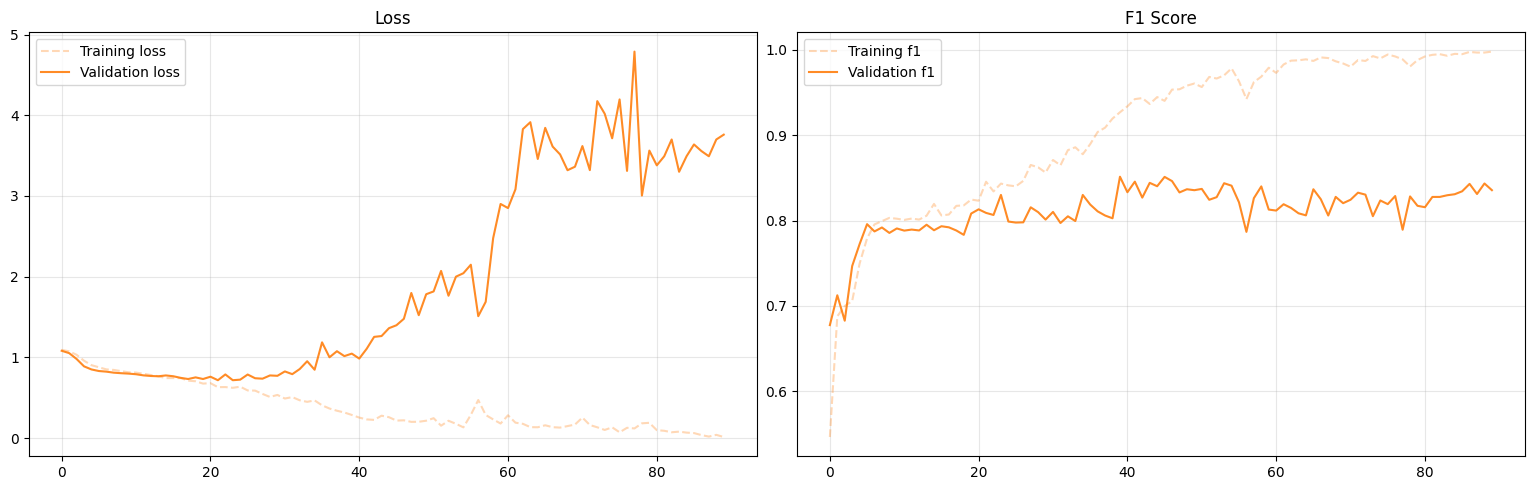

In [ ]:
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()


Accuracy over the validation set: 0.8541
Precision over the validation set: 0.8524
Recall over the validation set: 0.8541
F1 score over the validation set: 0.8514


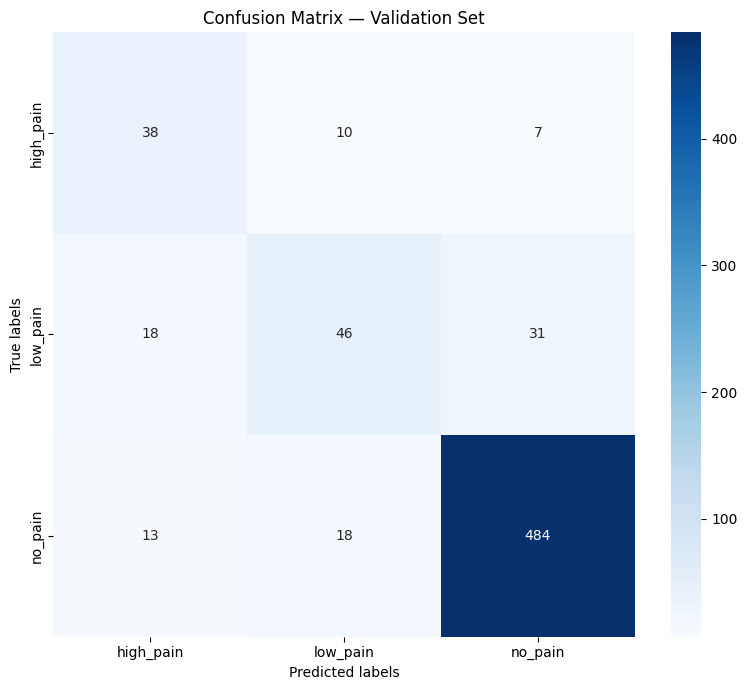

In [ ]:
val_preds, val_targets = [], []
with torch.no_grad():  
    
    for inputs, targets in val_loader: 
        
        if USE_STATIC_FEATURES:
            x_temporal, x_static = inputs
            x_temporal, x_static = x_temporal.to(device), x_static.to(device)
            logits = rnn_model(x_temporal, x_static)
        else:
            x_temporal = inputs 
            x_temporal = x_temporal.to(device)
            logits = rnn_model(x_temporal)

        preds = logits.argmax(dim=1).cpu().numpy()
        val_preds.append(preds)
        val_targets.append(targets.numpy()) 
    
# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted', zero_division=0)
val_rec = recall_score(val_targets, val_preds, average='weighted', zero_division=0)
val_f1 = f1_score(val_targets, val_preds, average='weighted', zero_division=0)
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)
class_names = list(label_map.keys())

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

## Parameters and Results Logging

In [ ]:
print("Training complete. Logging results...")

# 1. Find the best scores from the history
if training_history['val_f1']: 
    best_val_f1 = max(training_history['val_f1'])
    best_epoch_index = np.argmax(training_history['val_f1'])
    best_val_loss = training_history['val_loss'][best_epoch_index]
    best_epoch = best_epoch_index + 1 
else:
    best_val_f1 = 0.0
    best_val_loss = 0.0
    best_epoch = 0

try:
    with open("model_history.txt", "a") as f:
        # Get current time for the log entry
        log_time = timestamp
        
        f.write(f"--- Log Entry: {log_time} ---\n")
        f.write(f"Experiment Name: {experiment_name}\n")
        f.write("\n")
        f.write("Hyperparameters:\n")
        f.write(f"  - EPOCHS: {EPOCHS}\n")
        f.write(f"  - PATIENCE: {PATIENCE}\n")
        f.write(f"  - LEARNING_RATE: {LEARNING_RATE}\n")
        f.write(f"  - BATCH_SIZE: {BATCH_SIZE}\n")
        f.write(f"  - WINDOW_SIZE: {WINDOW_SIZE}\n")
        f.write(f"  - STRIDE: {STRIDE}\n")
        f.write(f"  - HIDDEN_LAYERS: {HIDDEN_LAYERS}\n")
        f.write(f"  - HIDDEN_SIZE: {HIDDEN_SIZE}\n")
        f.write(f"  - RNN_TYPE: {RNN_TYPE}\n")
        f.write(f"  - BIDIRECTIONAL: {BIDIRECTIONAL}\n")
        f.write(f"  - DROPOUT_RATE: {DROPOUT_RATE}\n")
        f.write(f"  - L2_LAMBDA (Weight Decay): {L2_LAMBDA}\n")
        f.write(f"  - L1_LAMBDA: {L1_LAMBDA}\n")
        f.write(f"  - NOISE_STD_DEV: {NOISE_STD_DEV}\n")
        f.write(f"  - USE_STATIC_FEATURES: {USE_STATIC_FEATURES}\n")
        if USE_STATIC_FEATURES:
            f.write(f"  - STATIC_HIDDEN_SIZE: {STATIC_HIDDEN_SIZE}\n")
            f.write(f"  - STATIC_FEATURES: {STATIC_FEATURES_LIST_ENGINEERED}\n")
        f.write("\n")
        f.write("Best Model Results (from Early Stopping):\n")
        f.write(f"  - Best Validation F1 Score: {best_val_f1:.4f}\n")
        f.write(f"  - Best Validation Loss: {best_val_loss:.4f}\n")
        f.write(f"  - Found at Epoch: {best_epoch}\n")
        f.write("--------------------------------------\n\n")
    
    print("Successfully wrote training results to model_history.txt")

except Exception as e:
    print(f"Error writing to model_history.txt: {e}")


Training complete. Logging results...
Successfully wrote training results to model_history.txt


## Prediction on Test

In [ ]:
if PREDICT_FLAG:
    class TestWindowDataset(Dataset):
        def __init__(self, X_temporal, X_static, window_sample_indices, static_map):
            self.X_temporal = torch.tensor(X_temporal, dtype=torch.float32)
            self.X_static_all = torch.tensor(X_static, dtype=torch.float32)
            self.window_sample_indices = window_sample_indices
            self.static_map = static_map

        def __getitem__(self, index):
            x_temporal_sample = self.X_temporal[index]
            sample_index = self.window_sample_indices[index]
            static_idx = self.static_map.get(sample_index)
            
            if static_idx is None:
                # Fallback for missing sample
                x_static_sample = torch.zeros(self.X_static_all.shape[1], dtype=torch.float32)
            else:
                x_static_sample = self.X_static_all[static_idx]
                
            return (x_temporal_sample, x_static_sample)
        
        def __len__(self):
            return self.X_temporal.shape[0]
            
    # This class is for the NON-HYBRID (standard) model
    class TestWindowDatasetStandard(Dataset):
        def __init__(self, data):
            self.data = data
        def __getitem__(self, index):
            return self.data[index]
        def __len__(self):
            return self.data.shape[0]

    print("\n--- Starting Test Set Prediction ---")
    df_test = pd.read_csv('pirate_pain_test.csv')

    float_cols = df_test.select_dtypes(include=['float64']).columns
    for col in float_cols:
        df_test[col] = df_test[col].astype(np.float32)
    inv_label_map = {v: k for k, v in label_map.items()}

    # --- 1. Create Static Test Features (if needed) ---
    if USE_STATIC_FEATURES:
        print("Engineering test set static features...")
        static_cols_raw_test = [c for c in df_test.columns if c.startswith('n_')]
        df_static_test_raw = df_test.drop_duplicates(subset=['sample_index']).set_index('sample_index')[static_cols_raw_test]

        df_static_test_engineered = engineer_static_features(df_static_test_raw)
        
        # Ensure columns match training (in case test set is missing a column)
        for col in STATIC_FEATURES_LIST_ENGINEERED:
            if col not in df_static_test_engineered:
                print(f"Warning: Test set missing static col '{col}'. Filling with 0.")
                df_static_test_engineered[col] = 0
                
        # Re-order columns to be certain
        df_static_test_engineered = df_static_test_engineered[STATIC_FEATURES_LIST_ENGINEERED]
        
        df_static_norm_test = (df_static_test_engineered - STATIC_TRAIN_MIN) / (STATIC_TRAIN_MAX - STATIC_TRAIN_MIN)
        df_static_norm_test = df_static_norm_test.fillna(0)
        
        static_map_test = {sid: i for i, sid in enumerate(df_static_norm_test.index)}
        static_data_test = df_static_norm_test.values

    # --- 2. Window the Test Data ---
    test_windows = []
    test_window_indices = [] 
    for sid in df_test['sample_index'].unique():
        seq_df = df_test[df_test['sample_index'] == sid]
        if len(seq_df) == 0:
            print(f"Warning: No features for test sample {sid}. Skipping.")
            continue
        seq = seq_df.sort_values('time')[feature_cols].values
        
        seq_tensor = torch.FloatTensor(seq)
        joint_data = seq_tensor[:, :len(joint_cols)]
        joint_min = joint_data.min(dim=0)[0]
        joint_max = joint_data.max(dim=0)[0]
        joint_range = joint_max - joint_min
        joint_range[joint_range == 0] = 1
        normalized_joints = 2 * ((joint_data - joint_min) / joint_range) - 1
        seq_tensor[:, :len(joint_cols)] = normalized_joints
        seq_normalized = seq_tensor.numpy()

        padding_len = WINDOW_SIZE - len(seq_normalized) % WINDOW_SIZE
        if padding_len < WINDOW_SIZE:
            padding = np.zeros((padding_len, input_size), dtype='float32')
            seq_padded = np.concatenate((seq_normalized, padding))
        else:
            seq_padded = seq_normalized
            
        idx = 0
        while idx + WINDOW_SIZE <= len(seq_padded):
            test_windows.append(seq_padded[idx:idx + WINDOW_SIZE])
            test_window_indices.append(sid)
            idx += STRIDE

    X_test_windows = np.array(test_windows)
    print(f"Created {len(X_test_windows)} test windows from {df_test['sample_index'].nunique()} samples.")

    # --- 3. Create Test DataLoader ---
    if USE_STATIC_FEATURES:
        test_dataset = TestWindowDataset(X_test_windows, static_data_test, test_window_indices, static_map_test)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    else:
        test_dataset = TestWindowDatasetStandard(torch.tensor(X_test_windows, dtype=torch.float32))
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # --- 4. Get predictions for ALL windows ---
    try:
        model_path = f"models/{experiment_name}_model.pt"
        rnn_model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Successfully loaded best model from {model_path}")
    except Exception as e:
        print(f"Warning: Could not load saved model. Using last epoch model. Error: {e}")

    rnn_model.eval() 
    window_predictions = []
    with torch.no_grad():
        for inputs in test_loader: 
            if USE_STATIC_FEATURES:
                x_temporal, x_static = inputs
                x_temporal, x_static = x_temporal.to(device), x_static.to(device)
                outputs = rnn_model(x_temporal, x_static)
            else:
                x_temporal = inputs
                x_temporal = x_temporal.to(device)
                outputs = rnn_model(x_temporal)
            
            pred = outputs.argmax(dim=1).cpu().numpy()
            window_predictions.extend(pred)
            
    # --- 5. Combine window predictions (Majority Vote) ---
    df_window_preds = pd.DataFrame({
        'sample_index': test_window_indices,
        'prediction': window_predictions
    })

    def get_majority_vote(x):
        return x.mode().iloc[0] 

    final_predictions = df_window_preds.groupby('sample_index')['prediction'].apply(get_majority_vote)

    # Format for submission
    submission_df = final_predictions.reset_index()
    submission_df['label'] = submission_df['prediction'].map(inv_label_map)
    submission_df['sample_index'] = submission_df['sample_index'].apply(lambda x: f"{int(x):03d}")

    all_test_sids = pd.DataFrame({'sample_index': [f"{int(idx):03d}" for idx in df_test['sample_index'].unique()]})
    submission_df = all_test_sids.merge(submission_df, on='sample_index', how='left')

    # Fill missing predictions with the training set's majority class
    if 'y_train' in locals() and len(y_train) > 0:
        majority_class_numeric = pd.Series(y_train).mode().iloc[0]
        majority_class_label = inv_label_map[majority_class_numeric]
    else:
        # Fallback in case y_train isn't available (shouldn't happen)
        majority_class_label = inv_label_map[0] 
        
    print(f"Filling {submission_df['label'].isna().sum()} missing predictions with majority class '{majority_class_label}'")
    submission_df['label'] = submission_df['label'].fillna(majority_class_label)

    # Save to CSV
    NAME_CSV_PREDICTION = f"submission_{timestamp}.csv"
    submission_df[['sample_index', 'label']].to_csv(NAME_CSV_PREDICTION, index=False)
    print(f"Predictions saved to {NAME_CSV_PREDICTION}")
    print(submission_df.head())
else:
    print("\n--- Prediction flag is set to False. Exiting without test predictions. ---")


--- Prediction flag is set to False. Exiting without test predictions. ---
